# 1D membrane transfer through an energy map

Code for a 1D analytical solving of the mass flux continuity through an energy map representing the membrane. It allows to the solute transmission, Tr (or the mass flux, j) and the counter osmotic pressure, CP (thus leading to link the permeate flux and the applied transmembrane pressure, TMP). When calculated, the concentration profile can be plotted.

Assumptions : 
- steady state
- linear energy map ramps
- ideal dispersion (constant diffusion and osmotic pressure prop to cc)

By considering the continuity of the mass flux all along the layers :
- 0 polarisation layer
- 1 exclusion layer
- 2 membrane
- 3 exclusion layer
- 4 polarisation layer

The higher concentration is on the left (feed or drawing solution), c0 and the lower concentration on the right (permeate or dialysate), c5. The permeate and the mass fluxes are positive from the leaf to the right.

Analytical solutions can be obtained by integration along the layers by considering the mass flux continuity :

$$J=\frac{L_p}{\mu}(\Delta P - CP)$$

### Mode with a normal flow in the permeate (case of classical filtration or reverse osmosis)

The transmission can be written :

$$Tr=\frac{\phi_p}{\phi_b}=\frac{1}{1+Ex\left(\frac{{(e}^{-({Pe}_{3}+Ex)}-1)e^{-{Pe}_{2}-{Pe}_{0}-{Pe}_{1}+Ex}}{{Pe}_{3}+Ex}+\frac{\left(1-e^{-{Pe}_{1}+Ex}\right)e^{-{Pe}_{0}}}{{Pe}_{1}-Ex}\right)}$$

$$CP=Tr\frac{{\mathrm{\Pi}_bEx}^2}{AB}\left({\frac{B}{A}(e}^{-A}-1)+\frac{A}{B}{(e}^{-B}-1)+A+B-{(e}^{-A}-1){(e}^{-B}-1)e^{-{Pe}_{2}}\right)$$

where ${A=Pe}_{1}-Ex $ and ${B=Pe}_{3}+Ex$

### Cross-flow mode in the permeate (case of forward osmosis or contactor)
  
The ratio $\frac{j}{J}$ can be written :

$$\frac{j}{J\phi_b}=\frac{1-\frac{\phi_p}{\phi_b}e^{-Pe_{0}-Pe_{1}-Pe_{2}-Pe_{3}-Pe_{4}}}{{1-e}^{-Pe_{0}}-\left(e^{-A}-1\right)\frac{Pe_{1}}{A}e^{-Pe_{0}}-\left(e^{-Pe_{2}}-1\right)e^{-Pe_{0}-A}-\left(e^{-B}-1\right)\frac{Pe_{3}}{B}e^{-Pe_{0}-A-Pe_{2}}-\left(e^{-Pe_{4}}-1\right)e^{-Pe_{0}-A-Pe_{2}-B}}$$

$$CP=\mathrm{\Pi}_b\frac{j}{J\phi_b}\frac{Ex^2}{AB}\left(\frac{B\left(e^{-A}-1\right)}{A}+\frac{A\left(e^{-B}-1\right)}{B}+A+B-\left(e^{-A}-1\right)\left(e^{-B}-1\right)e^{-Pe_{2}}\right)$$

The TMP can be directly determined from a given permeate flux (first part of the code). For a given TMP, it is necessary to solve the 3 equations (second part of the code).

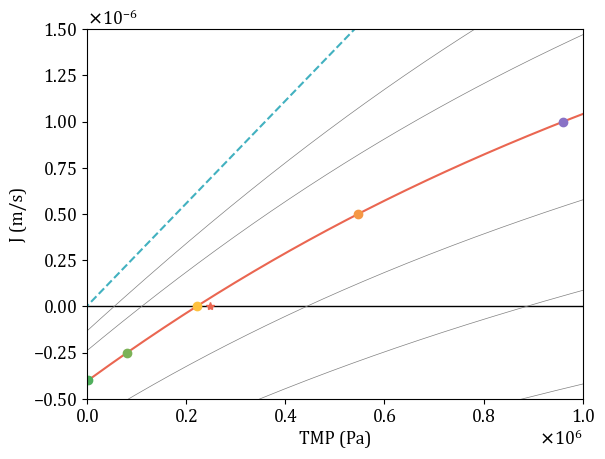

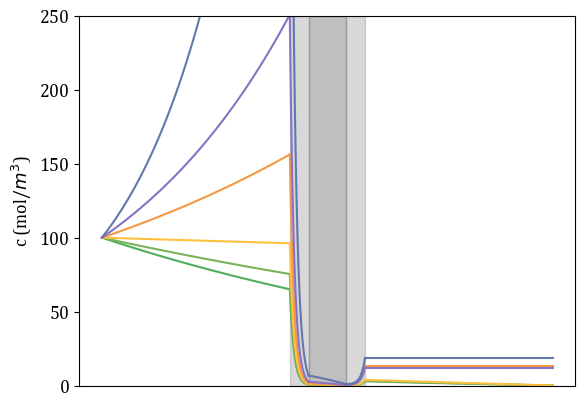

In [4]:
# Code for the calculation of TMP for given J
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font',family='cambria', size = 13)
#Data
K=1e-2              # Ppartition coeff
Ex = -np.log(K)     # Exclusion number
Lp=1                # Membrane permeability L/(h.m2.bar)
Lp=Lp*1e-3/3600/1e5 # Permeability m.s-1.Pa-1
R=8.314             # Constant J mol-1 K-1
T=298               # Temperature K
c0 = 100            # Concentration left mol/m3
c5 = 0.00001        # Concentration right mol/m3
k = (1e-6, 1e-5, 5e-6, 1e-5, 1e-6) # Mass transfer coefficient
#  k0 PL,k1 Exc,k2 Mem,k3 Exc,k4 PL

#Range of permeate flux and of Peclet number
J=np.linspace(-1e-6,5e-6,1000)
Pe=np.array([J/k[0],J/k[1],J/k[2],J/k[3],J/k[4]])

# Calcul of exponential terms from Pe and Ex
def expo(Pe,Ex):
    return np.exp(-Pe[0]), np.exp(-Pe[1]+Ex), np.exp(-Pe[2]), np.exp(-Pe[3]-Ex), np.exp(-Pe[4]), Pe[1]-Ex, Pe[3]+Ex

# Calcul of j over J c0 (contactor mode)
def j_J(Pe,Ex,rc):
    e0, e1, e2, e3, e4, A, B = expo(Pe, Ex)
    return (rc*e1*e2*e3*e4-1/e0)/((1-1/e0)+(e1-1)*Pe[1]/A+(e2-1)*e1+(e3-1)*e2*e1*Pe[3]/B+(e4-1)*e3*e2*e1)

# Calcul of transmission (filtration mode)
def Tr(Pe,Ex):
    e0, e1, e2, e3, e4, A, B = expo(Pe, Ex)
    return 1/(1+Ex*((e3-1)*e2*e1*e0/B+((1-e1)*e0/A)))

# Calcul of Counter pressure (adimensionnal form: should be multiplied by RTc0)
def CP(Pe,Ex):
    e0, e1, e2, e3, e4, A, B = expo(Pe, Ex)
    CP=(Ex*Ex/(A*B))*(B*(e1-1)/A+A*(e3-1)/B+A+B-(e1-1)*(e3-1)*e2)
    return CP

# Calcul of j over J c0 when J<=0 (contactor mode) and of tranmission (filtration mode) when J>0
TR=np.zeros_like(J)
for i,Ji in enumerate(J) :
    Pei=np.array([Ji/k[0],Ji/k[1],Ji/k[2],Ji/k[3],Ji/k[4]])
    if Ji<=0:
        TR[i]=j_J(Pei,Ex,c5/c0)
    if Ji>0:
        TR[i]=Tr(Pei,Ex)

Jlist=([-0.4e-6,-0.25e-6,-1e-12,0.5e-6,1e-6,2e-6])
colors=([(80/256,176/256,93/256),(124/256,179/256,87/256),(255/256,194/256,63/256),
             (246/256,153/256,69/256),(138/256,114/256,199/256),(98/256,119/256,171/256)])

# plot J versus TMP
plt.plot(J/Lp , J, color=(66/256,178/256,193/256),linestyle='--')
plt.plot(J/Lp + j_J(Pe,Ex,c5/c0)*CP(Pe,Ex)*R*T*c0, J, color=(235/256,102/256,81/256))
plt.plot(J/Lp + j_J(Pe,Ex,c5/25)*CP(Pe,Ex)*R*T*25, J, 'gray', linewidth=0.5)
plt.plot(J/Lp + j_J(Pe,Ex,c5/50)*CP(Pe,Ex)*R*T*50, J, 'gray', linewidth=0.5)
plt.plot(J/Lp + j_J(Pe,Ex,c5/200)*CP(Pe,Ex)*R*T*200, J, 'gray', linewidth=0.5)
plt.plot(J/Lp + j_J(Pe,Ex,c5/400)*CP(Pe,Ex)*R*T*400, J, 'gray', linewidth=0.5)
plt.plot(J/Lp + j_J(Pe,Ex,c5/800)*CP(Pe,Ex)*R*T*800, J, 'gray', linewidth=0.5)
plt.plot(R*T*(c0-c5),0,color=(235/256,102/256,81/256),marker="*")
#plt.grid()
for i, Jp in enumerate(Jlist):
    Pep=np.array([Jp/k[0],Jp/k[1],Jp/k[2],Jp/k[3],Jp/k[4]])
    plt.plot(Jp/Lp + j_J(Pep,Ex,c5/c0)*CP(Pep,Ex)*R*T*c0,Jp,color=colors[i],marker="o")
plt.xlim(0,1e6)
plt.ylim(-0.5e-6,1.5e-6)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
plt.axhspan(0,0, color='k')
plt.xlabel('TMP (Pa)')
plt.ylabel('J (m/s)')
plt.show()

# function to plot a profile for a given J
def profile(Jp,c0,c5,col):
    Pep=np.array([Jp/k[0],Jp/k[1],Jp/k[2],Jp/k[3],Jp/k[4]])
    if Jp>0:
        jJ=Tr(Pep,Ex)*c0
    if Jp<=0:
        jJ=j_J(Pep,Ex,c5/c0)*c0
    e0, e1, e2, e3, e4, A, B = expo(Pep, Ex)
    c1=jJ*(1-1/e0)+c0/e0
    c2=jJ*(1-1/e1)*Pep[1]/(Pep[1]-Ex)+c1/e1
    c3=jJ*(1-1/e2)+c2/e2
    c4=jJ*(1-1/e3)*Pep[3]/(Pep[3]+Ex)+c3/e3
    x=np.linspace(0,1,50)
    plt.plot(x,(c0-jJ)*np.exp(Pep[0]*x)+jJ,color=col)
    plt.plot(x*k[0]/k[1]+1,(c1-jJ*Pep[1]/(Pep[1]-Ex))*np.exp((Pep[1]-Ex)*x)+jJ*Pep[1]/(Pep[1]-Ex),color=col)
    plt.plot(x*k[0]/k[2]+1+k[0]/k[1],(c2-jJ)*np.exp(Pep[2]*x)+jJ,color=col)
    plt.plot(x*k[0]/k[3]+1+k[0]/k[1]+k[0]/k[2],(c3-jJ*Pep[3]/(Pep[3]+Ex))*np.exp((Pep[3]+Ex)*x)+jJ*Pep[3]/(Pep[3]+Ex),color=col)
    plt.plot(x*k[0]/k[4]+1+k[0]/k[1]+k[0]/k[2]+k[0]/k[3],(c4-jJ)*np.exp(Pep[4]*x)+jJ,color=col)
    plt.ylim(0,c0*3)
    plt.ylabel('c (mol/$m^3$)')
    plt.xticks([]) 
    
for i, Jp in enumerate(Jlist):
    profile(Jlist[i],c0,c5, colors[i])

plt.axvspan(1, 1+k[0]/k[1], alpha=0.3, color='grey')
plt.axvspan(1+k[0]/k[1], 1+k[0]/k[1]+k[0]/k[2], alpha=0.5, color='grey')
plt.axvspan(1+k[0]/k[1]+k[0]/k[2], 1+k[0]/k[1]+k[0]/k[2]+k[0]/k[3], alpha=0.3, color='grey')
plt.ylim(0,250)
plt.show()



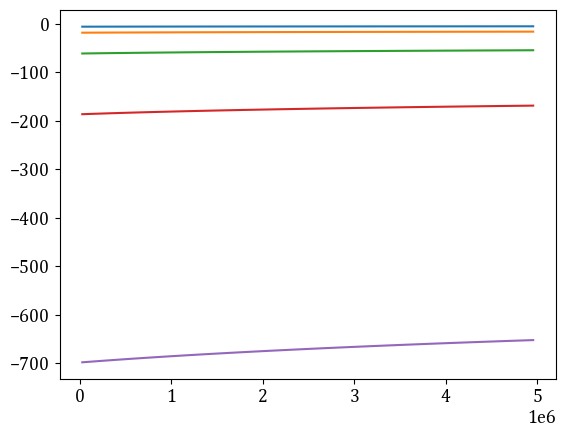

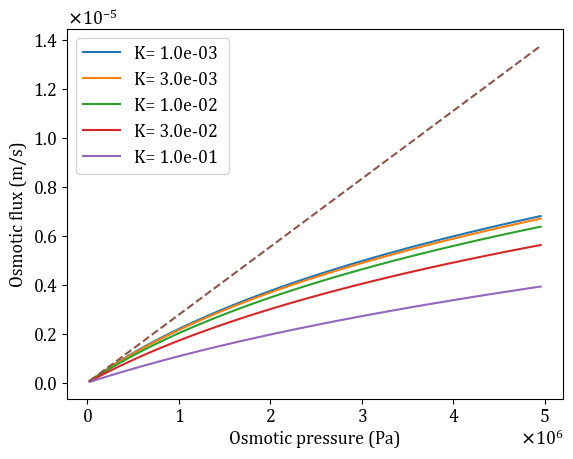

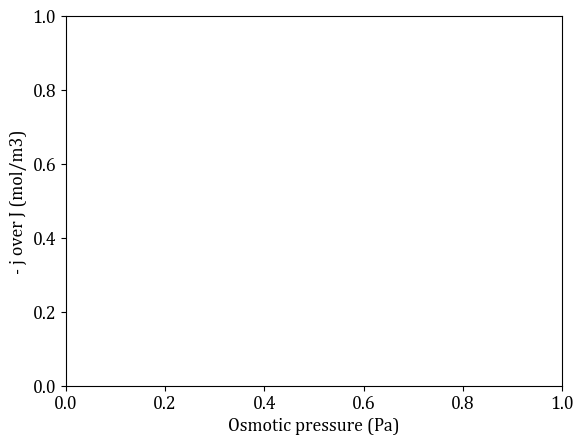

In [5]:
from scipy.optimize import fsolve
k = (1e-5, 1e-4, 5e-5, 1e-4, 1e-5) # Mass transfer coefficient
# Code for the calculation of J for a given TMP or a given c0
TMP_list=([1e6,2e6]) #Pa
c0_list=np.linspace(10, 2000,50) #Pa
K_list=np.array([0.001, 0.003, 0.01,0.03,0.1])
Ex_list=-np.log(K_list)
rc=0    #c5/c0

#Function to solve to find the permeate flux, J
def target(J, TMP, Ex, c0, rc):
    Pe=np.array([J/k[0],J/k[1],J/k[2],J/k[3],J/k[4]])
    return J/Lp - TMP + j_J(Pe,Ex,rc)*CP(Pe,Ex)*R*T*c0

# Calculation of J for a given TMP
Jp=np.zeros_like(TMP_list)
c0=100
for i, TMP in enumerate(TMP_list):
    Jp[i]=fsolve(target, x0=Lp*TMP, args=(TMP, Ex, c0, rc))[0]

# Calculation of J for a given c0
Jc=np.zeros((len(c0_list), len(Ex_list)))
TMP=0
for j, Ex in enumerate(Ex_list):
    for i, c0 in enumerate(c0_list):
        Jc[i,j]=fsolve(target, x0=-Lp*R*T*c0, args=(TMP, Ex, c0, rc))[0]
    plt.figure(1)
    plt.plot(R*T*c0_list, -Jc[:,j], label="K= %.1e " % K_list[j])


plt.plot(R*T*c0_list, Lp*R*T*c0_list, '--')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
plt.xlabel('Osmotic pressure (Pa)')
plt.ylabel('Osmotic flux (m/s)')
plt.legend()
plt.show()
